# Introduction to `Cal-PIT`

Reproduce Example-1 from the Paper


In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import numpy as np
import pandas as pd
import pickle
import pdb
import time
from tqdm.auto import tqdm
from cdetools.cdf_coverage import cdf_coverage
from cdetools.hpd_coverage import hpd_coverage
from cdetools.cde_loss import cde_loss
import scipy
import scipy.stats as stats
from scipy.stats import norm, multivariate_normal
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.integrate import simps
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mtick
from pathlib import Path
# from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes, tight_layout#, hold
# from matplotlib.lines import Line2D

# from ispline import *
# from calib_utils import compute_mixture_pdf, compute_dist_split_sets, compute_CalPITINT_sets, \
#     calc_HPD_indexes, compute_HPD_sets, check_HPD_coverage_single_set, calc_length_HPD_sets
# from run_mdn_k import run_mdn_k
# from mlp_training import RandomDataset, count_parameters,EarlyStopping, MLP, train_local_pit, get_local_pit, load_model
# from utils import normalize
# import rfcde
import flexcode
from flexcode.regression_models import XGBoost  
from scipy.interpolate import interp1d

import torch
from torch import nn
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset, DataLoader, TensorDataset
from prettytable import PrettyTable
# from .utils import get_pit
# from .nn.nn_utils import CalPitLitModule, RandomDataset

In [80]:
### set seed for reproducibility
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

params = {
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "figure.facecolor": "w",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif"
}
plt.rcParams.update(params)


# generate data

### $X_{i,1-2} \sim \text{Uniform}[-5,5]^{2}$

### $X_{i,0} \sim \text{Bern}(0.2)$

### if $X_{i,1} < 0$:
### $Y_i = \begin{cases} 0.3 \beta^T X_i \epsilon_{1,i}, & X_{i,0}=0 \\ 0.3 \gamma^T X_i \epsilon_{1,i} + \lambda \epsilon_{2,i}, & X_{i,0}=1 \end{cases}$

### if $X_{i,1} > 0$:
### $Y_i = \begin{cases} X_{i,1} + 0.3 \beta^T X_i \epsilon_{1,i}, & X_{i,0}=0 \\ -X_{i,1} + 0.3 \gamma^T X_i \epsilon_{1,i} + \lambda \epsilon_{2,i}, & X_{i,0}=1 \end{cases}$

In [81]:
def generate_data(n=7000, d=3, lam=3, seed=42):
    
    rng = np.random.default_rng(seed=seed)
    
    X_unif = rng.uniform(low=-5, high=5, size=n*(d-1)).reshape(n, d-1)
    X_bern = rng.binomial(n=1, p=0.2, size=n)
    
    eps1 = rng.normal(loc=0, scale=1, size=n)
    eps2 = rng.normal(loc=0, scale=0.1, size=n)
    
    X_data = np.hstack([X_bern.reshape(-1,1), X_unif])
    
    double_fork = X_data[:,1] > 0
    
    Y_data = (1-X_bern) * (lam * eps2 + 0.2 * (X_data[:,1] + 5) * eps1) + \
                X_bern * (lam * eps2 - 0.2 * (X_data[:,1] - 5) * eps1)
    
    Y_data += double_fork*(1-X_bern)*1*X_data[:,1] - double_fork*X_bern*1*X_data[:,1]
    
    return X_data, Y_data

In [82]:
n_train = 5000
n_calib = 5000
n_test = 1000
d = 3
lam = 3

In [83]:
use_X, use_Y = generate_data(n=n_train+n_calib+n_test, d=d, lam=lam, seed=SEED)
X_test = use_X[-n_test:, 1:]
Y_test = use_Y[-n_test:]

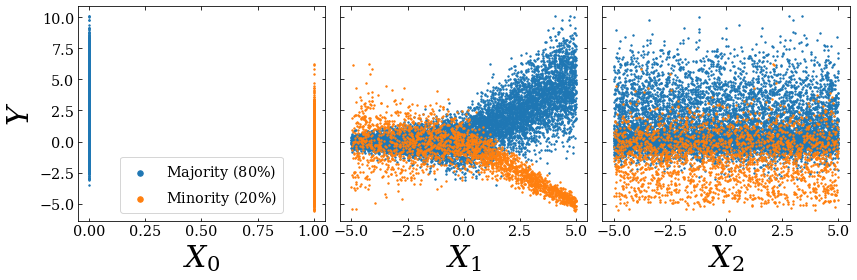

In [84]:
x, y = use_X, use_Y

fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
mask = (x[:,0]==0)
s=2
ax[0].scatter(x[:,0][mask],y[mask], c="C0",s=s, label=r"$\mathrm{Majority\ (80\%)}$")
ax[0].scatter(x[:,0][~mask],y[~mask], c="C1",s=s, label=r"$\mathrm{Minority\ (20\%)}$")
ax[0].set_ylabel(r"$Y$", fontsize=30)
ax[0].set_xlabel(r"$X_{0}$", fontsize=30)
lgnd = ax[0].legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

ax[1].scatter(x[:,1][mask],y[mask], c="C0", s=s)
ax[1].scatter(x[:,1][~mask],y[~mask], c="C1", s=s)
ax[1].set_xlabel(r"$X_{1}$", fontsize=30)

ax[2].scatter(x[:,2][mask],y[mask], c="C0", s=s)
ax[2].scatter(x[:,2][~mask],y[~mask], c="C1", s=s)
ax[2].set_xlabel(r"$X_{2}$", fontsize=30)

plt.tight_layout()
plt.show()

Starting guess

In [85]:
n_grid = 200

y_grid = np.linspace(-5,5,n_grid)
cde_init = np.ones((n_calib,n_grid))
cde_init = cde_init/np.trapz(cde_init, y_grid)[:,None]

Text(0.5, 1.0, 'Initial CDE')

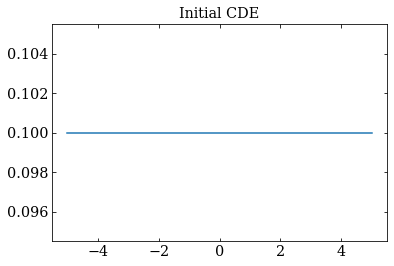

In [86]:
plt.plot(y_grid, cde_init[0])
plt.title("Initial CDE")

In [87]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

class MLP(nn.Module):
    def __init__(self, input_dim=6, output_dim=1, hidden_layers=[512,512,512]):
        super().__init__()
        self.all_layers = [input_dim]
        self.all_layers.extend(hidden_layers)
        self.all_layers.append(output_dim)
        
        self.layer_list=[]
        for i in range(len(self.all_layers)-1):
            self.layer_list.append(nn.Linear(self.all_layers[i], self.all_layers[i+1]))
            self.layer_list.append(nn.PReLU())
            
        self.layer_list.pop()
        # self.layer_list.append( nn.Sigmoid())
        self.layers = nn.Sequential(*self.layer_list)
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.layers.apply(init_weights)
        
    
    def forward(self, x):

        return self.layers(x)


class RandomDataset(Dataset):
    def __init__(self, X, Y, oversample=1):
        self.X = X
        self.Y = Y
        self.len_x = len(X)
        self.oversample = oversample

    def __len__(self):
        return int(len(self.X) * self.oversample)

    def __getitem__(self, idx):
        alpha = torch.rand(1)
        feature = torch.hstack((alpha, torch.Tensor(self.X[idx % self.len_x])))
        target = (self.Y[idx % self.len_x] <= alpha).float()
        return feature, target
    
    
def load_model(input_size, hidden_layers,checkpt_path, nn_type="monotonic",sigmoid=False, gpu_id="cuda:0"):
    # Use gpu if available
    device = torch.device(gpu_id if torch.cuda.is_available() else "cpu")
    if nn_type == "mlp":
        rhat = MLP(input_size,1, hidden_layers).to(device)
    if nn_type == "monotonic":
        rhat = MonotonicNN(input_size, hidden_layers, nb_steps=200, dev=device, sigmoid=sigmoid).to(device)
        
    count_parameters(rhat)
    rhat.load_state_dict(torch.load(checkpt_path))
    
    return rhat


# TODO
- Add sigmoid
- Add UMNN

In [ ]:
model(spectra) --> 1 number between 0 and 1 

final layer 1 output with sigmoid activation. 

In [90]:
class CalPit:
    def __init__(self, model, input_size =None, hidden_layers=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if model == "mlp":
            self.model = MLP(input_size+1,1, hidden_layers).to(self.device)
        elif model == "mlp_monotonic":
            self.model = MonotonicNN(input_size+1, hidden_layers, nb_steps=200, dev=self.device, sigmoid=sigmoid).to(self.device)
        else:
            self.model = model.to(device)

        count_parameters(self.model)
        
    def fit(
        self,
        x_calib,
        y_calib=None,
        cde_calib=None, 
        cde_grid=None,
        pit_values_calib=None,
        patience=20,
        n_epochs=1000,
        lr=0.001,
        weight_decay=1e-5,
        batch_size=2048,
        frac_mlp_train=0.9,
        lr_decay=0.99,
        trace_func=print,
        oversample=1,
        n_alpha=201,
        checkpt_path="./checkpoint_.pt"):
        
        self.x_calib = x_calib
        if pit_values_calib is None:
            if y_calib is None or cde_calib is None or cde_grid is None:
                raise ValueError(
                    "Either pit_values_calib or y_calib and cde_calib and cde_grid must be provided"
                )
        if pit_values_calib is not None:
            self.pit_values_calib = pit_values_calib
        else:
            self.y_calib = y_calib
            self.cde_calib = cde_calib
            self.cde_grid = cde_grid
            self.pit_values_calib = get_pit(self.cde_calib, self.cde_grid, self.y_calib)

        train_size = int(frac_train * len(self.x_calib))

        rnd_idx = np.random.default_rng().permutation(len(self.x_calib))
        x_train_rnd = self.x_calib[rnd_idx[:train_size]]
        x_val_rnd = self.x_calib[rnd_idx[train_size:]]
        pit_train_rand = self.pit_values_calib[rnd_idx[:train_size]]
        pit_val_rand = self.pit_values_calib[rnd_idx[train_size:]]

        # Creat randomized Data set for training
        trainset = RandomDataset(x_train_rnd, pit_train_rand, oversample=oversample)

        # Create static dataset for validation
        feature_val = torch.cat(
            [
                torch.Tensor(np.repeat(alphas_grid, len(x_val_rnd)))[:, None],
                torch.Tensor(np.tile(x_val_rnd, (len(alphas_grid), 1))),
            ],
            dim=-1,
        )
        target_val = torch.Tensor(
            np.tile(pit_val_rand, len(alphas_grid)) <= np.repeat(alphas_grid, len(x_val_rnd))
        ).float()

        validset = TensorDataset(feature_val, target_val)

        # Create Data loader
        train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        valid_dataloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        
        return self.model

    # def predict_pit(self, X_test, n_gamma, gamma_grid):
    #     return 0
    # def predict_cde(self,)

In [91]:


model = CalPit(model="mlp",input_size=2, hidden_layers=[128,128])


model.fit(Calibration data)

model.predict_cde(New spectra) --> Corrected PDFS

model.predict_pit(New Spectra) --> Local Probability Probability plots

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| layers.0.weight |    384     |
|  layers.0.bias  |    128     |
| layers.1.weight |     1      |
| layers.2.weight |   16384    |
|  layers.2.bias  |    128     |
| layers.3.weight |     1      |
| layers.4.weight |    128     |
|  layers.4.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 17155
